<a href="https://colab.research.google.com/github/wendycataldo/A_dissertacao/blob/main/Avalia%C3%A7%C3%A3o_do_questionario_professores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cabeçalho

In [92]:
!pip install scikit-posthocs

In [93]:
import pandas as pd
import re

from google.colab import drive

In [94]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
caminho_questionario = '/content/drive/MyDrive/Analises dados dis/Experimento (respostas).xlsx'

df_questionario = pd.read_excel(caminho_questionario)

In [96]:
novos_nomes = {
    '1 - Qual sua idade?': 'Idade',
    '2 - Você possui pós-graduação?': 'Pos_Graduacao',
    '3- Instituição de ensino que leciona atualmente (ou a principal, caso lecione em mais de uma)?': 'Instituicao',
    '4 - Há quanto tempo você atua como professor(a) (considerando todas as disciplinas e níveis)?': 'Tempo_Experiencia',
    '5 - Com que frequência você elabora suas próprias questões para as avaliações que aplica?': 'Frequencia_Elaboracao',
    '6 - Em média, quanto tempo você dedica à criação de exercícios e avaliações para uma turma por semana?': 'Tempo_Dedicado',
    '7 - Como você avalia seu nível de estresse como professor?': 'Nivel_Estresse',
    '8 - Como você avalia sua satisfação profissional como professor?': 'Satisfacao_Profissional',
    '9 - Você já utilizou alguma ferramenta específica para criar questões anteriormente?': 'Ferramentas_Anteriores',
    '10 - Especificamente sobre LLMs como ChatGPT, Gemini, etc., você já teve experiência prévia em usá-los para alguma finalidade (profissional ou pessoal)?': 'Experiencia_LLMs',
    '11 - Você acredita que o uso do LLM pode ser uma ferramenta útil para professores na criação de exercícios?': 'Utilidade_LLMs'
}

df_questionario = df_questionario.rename(columns=novos_nomes)

In [97]:
colunas_perfil = [
    'Carimbo de data/hora',
    'Declaro ter lido e aceito o TCLE acima exposto.',
    'Idade',
    'Pos_Graduacao',
    'Instituicao',
    'Tempo_Experiencia',
    'Frequencia_Elaboracao',
    'Tempo_Dedicado',
    'Nivel_Estresse',
    'Satisfacao_Profissional',
    'Ferramentas_Anteriores',
    'Experiencia_LLMs',
    'Utilidade_LLMs'
]

In [98]:
criterios_validos = [
    "Cobertura",
    "Gramaticalidade",
    "Utilidade",
    "Relevância",
    "Capacidade de resposta"
]

# Constrói padrão de critérios
padrao_criterios = "|".join([re.escape(c) for c in criterios_validos])

# Regex robusta, aceita múltiplos espaços, e separa sempre: questao + criterio + llm + opcional Meta/prompt
padrao_regex = re.compile(
    rf'^\s*(\d+)\s+({padrao_criterios})\s+(DeepSeek|Mistal|ChatGPT|Professor)(?:\s+(Meta|prompt))?\s*$',
    re.IGNORECASE
)
def separa_coluna(col_nome):
    col_nome = re.sub(r'\s+', ' ', col_nome.strip()) # Normaliza espaços
    m = padrao_regex.match(col_nome)
    if m:
        n_quest = int(m.group(1))
        criterio = m.group(2).strip()
        llm = m.group(3).strip()
        tipo_prompt = m.group(4) if m.group(4) else ("Professor" if llm.lower() == "professor" else "prompt")
        return n_quest, criterio, llm, tipo_prompt
    else:
        return None, None, None, None

# Confirme no DataFrame:
colunas_criterios = [col for col in df_questionario.columns if col not in colunas_perfil]

# TRANSFORMAÇÃO PARA FORMATO LONG
avaliacoes_long = []
for idx, row in df_questionario.iterrows():
    perfil = row[colunas_perfil].to_dict()
    for col in colunas_criterios:
        valor = row[col]
        n_q, criterio, llm, tipo_prompt = separa_coluna(col)
        if criterio:
            avaliacoes_long.append({
                **perfil,
                'Questao': n_q,
                'Criterio': criterio,
                'LLM': llm,
                'Tipo_Prompt': tipo_prompt,
                'Valor': valor
            })

df_long = pd.DataFrame(avaliacoes_long)

In [99]:
print(df_long['Criterio'].unique())
print(df_long['LLM'].unique())
print(df_long['Tipo_Prompt'].unique())

['Cobertura' 'Gramaticalidade' 'Utilidade' 'Relevância'
 'Capacidade de resposta']
['Professor' 'DeepSeek' 'Mistal' 'ChatGPT']
['Professor' 'prompt' 'Meta']


In [100]:
df_long.groupby(['Criterio', 'LLM', 'Tipo_Prompt'])['Valor'].agg(['mean', 'std', 'count'])

mean       std  count
Criterio               LLM       Tipo_Prompt                           
Capacidade de resposta ChatGPT   Meta         4.251029  1.043847    243
                                 prompt       4.049383  1.187760    243
                       DeepSeek  Meta         4.259259  0.941835    243
                                 prompt       4.230453  1.030716    243
                       Mistal    Meta         4.316872  0.950426    243
                                 prompt       4.189300  1.066570    243
                       Professor Professor    4.401235  0.999751    162
Cobertura              ChatGPT   Meta         4.160494  0.972219    243
                                 prompt       4.049383  0.998775    243
                       DeepSeek  Meta         4.213992  0.980960    243
                                 prompt       4.123457  1.008838    243
                       Mistal    Meta         4.102881  1.099263    243
                                 prompt       3.921811  1.116211    243
                       Professor Professor    4.246914  0.984739    162
Gramaticalidade        ChatGPT   Meta         4.345679  0.997855    243
                                 prompt       4.267490  1.047652    243
                       DeepSeek  Meta         4.337449  1.045117    243
                                 prompt       4.337449  0.984024    243
                       Mistal    Meta         4.415638  0.951338    243
                                 prompt       4.329218  1.027841    243
                       Professor Professor    4.388889  1.010811    162
Relevância             ChatGPT   Meta         4.218107  1.011178    243
                                 prompt       4.061728  1.087255    243
                       DeepSeek  Meta         4.069959  1.101859    243
                                 prompt       4.074074  1.061472    243
                       Mistal    Meta         4.106996  1.006627    243
                                 prompt       4.102881  1.064894    243
                       Professor Professor    4.277778  0.998446    162
Utilidade              ChatGPT   Meta         4.057613  1.022865    243
                                 prompt       3.979424  0.989401    243
                       DeepSeek  Meta         4.189300  0.943206    243
                                 prompt       4.053498  1.025107    243
                       Mistal    Meta         4.053498  1.017013    243
                                 prompt       3.958848  1.163474    243
                       Professor Professor    4.179012  0.925178    162

# Analises

1. Estatísticas descritivas por Critério, LLM e Tipo de Prompt

In [101]:
# Estatísticas resumidas (média, desvio, contagem)
estatisticas = (
    df_long
    .groupby(['Criterio', 'LLM', 'Tipo_Prompt'])['Valor']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .rename(columns={'mean': 'Media', 'std': 'Desvio_Padrao', 'count': 'N'})
)
print(estatisticas)


                  Criterio        LLM Tipo_Prompt     Media  Desvio_Padrao  \
0   Capacidade de resposta    ChatGPT        Meta  4.251029       1.043847   
1   Capacidade de resposta    ChatGPT      prompt  4.049383       1.187760   
2   Capacidade de resposta   DeepSeek        Meta  4.259259       0.941835   
3   Capacidade de resposta   DeepSeek      prompt  4.230453       1.030716   
4   Capacidade de resposta     Mistal        Meta  4.316872       0.950426   
5   Capacidade de resposta     Mistal      prompt  4.189300       1.066570   
6   Capacidade de resposta  Professor   Professor  4.401235       0.999751   
7                Cobertura    ChatGPT        Meta  4.160494       0.972219   
8                Cobertura    ChatGPT      prompt  4.049383       0.998775   
9                Cobertura   DeepSeek        Meta  4.213992       0.980960   
10               Cobertura   DeepSeek      prompt  4.123457       1.008838   
11               Cobertura     Mistal        Meta  4.102881     

2. Gráfico de comparação (exemplo: Cobertura)

/tmp/ipython-input-102-66097624.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


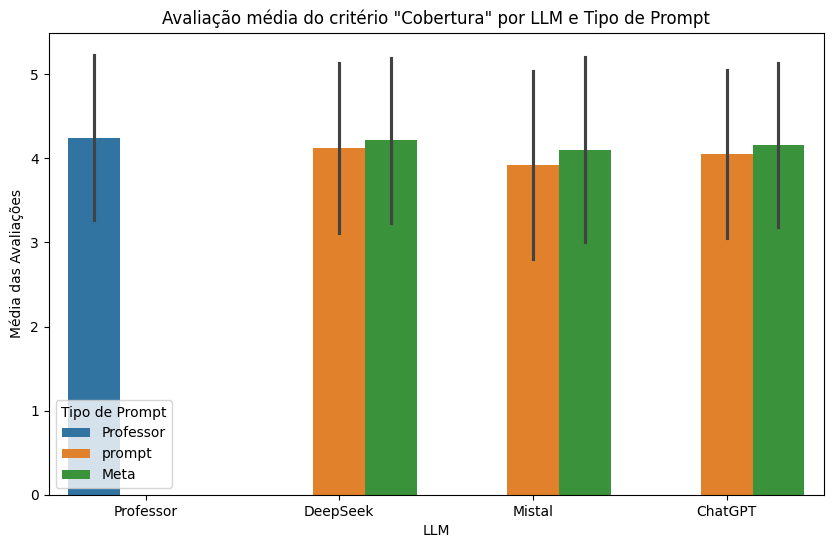

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

criterio_exemplo = 'Cobertura'  # Pode trocar por outro critério

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_long[df_long['Criterio']==criterio_exemplo],
    x='LLM',
    y='Valor',
    hue='Tipo_Prompt',
    ci='sd'
)
plt.title(f'Avaliação média do critério "{criterio_exemplo}" por LLM e Tipo de Prompt')
plt.ylabel('Média das Avaliações')
plt.xlabel('LLM')
plt.legend(title='Tipo de Prompt')
plt.show()


3. Estatísticas por questão (opcional, detalhamento por questão)

In [103]:
estatisticas_questao = (
    df_long
    .groupby(['Questao', 'Criterio', 'LLM', 'Tipo_Prompt'])['Valor']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)
print(estatisticas_questao.head())


   Questao                Criterio        LLM Tipo_Prompt      mean       std  \
0        1  Capacidade de resposta  Professor   Professor  4.382716  1.067332   
1        1               Cobertura  Professor   Professor  4.234568  1.087102   
2        1         Gramaticalidade  Professor   Professor  4.358025  1.028453   
3        1              Relevância  Professor   Professor  4.271605  1.036971   
4        1               Utilidade  Professor   Professor  4.222222  0.935414   

   count  
0     81  
1     81  
2     81  
3     81  
4     81  


# Análise por perfil docente

1. Exemplo: Médias por nível de experiência docente
(para cada LLM e tipo de prompt, sempre na mesma escala)

Primeiro, transforme a experiência em um dado numérico ordenável:

In [104]:
# Mapeamento de faixas de experiência para valores médios aproximados (ajuste conforme seu questionário!)
map_exp = {
    'Menos de 1 ano': 0.5,
    '1 a 5 anos': 3,
    '6 a 10 anos': 8,
    '11 a 15 anos': 13,
    '16 a 20 anos': 18,
    'Mais de 20 anos': 25
}
df_long['Tempo_Experiencia_Num'] = df_long['Tempo_Experiencia'].map(map_exp)

2. Gráfico: Avaliação média por Tempo de Experiência (anos), LLM e Tipo_Prompt
(vou usar “Cobertura” como exemplo; troque para outro critério se desejar)

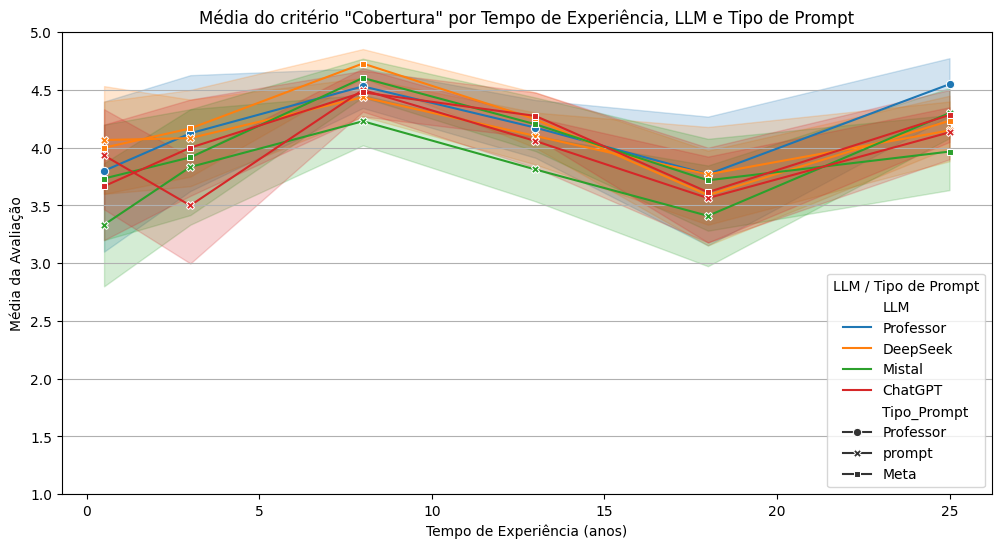

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

criterio_exemplo = 'Cobertura'

plt.figure(figsize=(12,6))

sns.lineplot(
    data=df_long[df_long['Criterio']==criterio_exemplo],
    x='Tempo_Experiencia_Num',
    y='Valor',
    hue='LLM',
    style='Tipo_Prompt',
    markers=True,
    dashes=False,
    palette='tab10'
)

plt.ylim(1,5)  # Escala padronizada da variável Valor (ajuste se seus dados forem de outra faixa)
plt.title(f'Média do critério "{criterio_exemplo}" por Tempo de Experiência, LLM e Tipo de Prompt')
plt.xlabel('Tempo de Experiência (anos)')
plt.ylabel('Média da Avaliação')
plt.legend(title='LLM / Tipo de Prompt')
plt.grid(True, axis='y')
plt.show()


3. Gráfico de barras: Comparação por categoria de experiência

/tmp/ipython-input-106-516565636.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


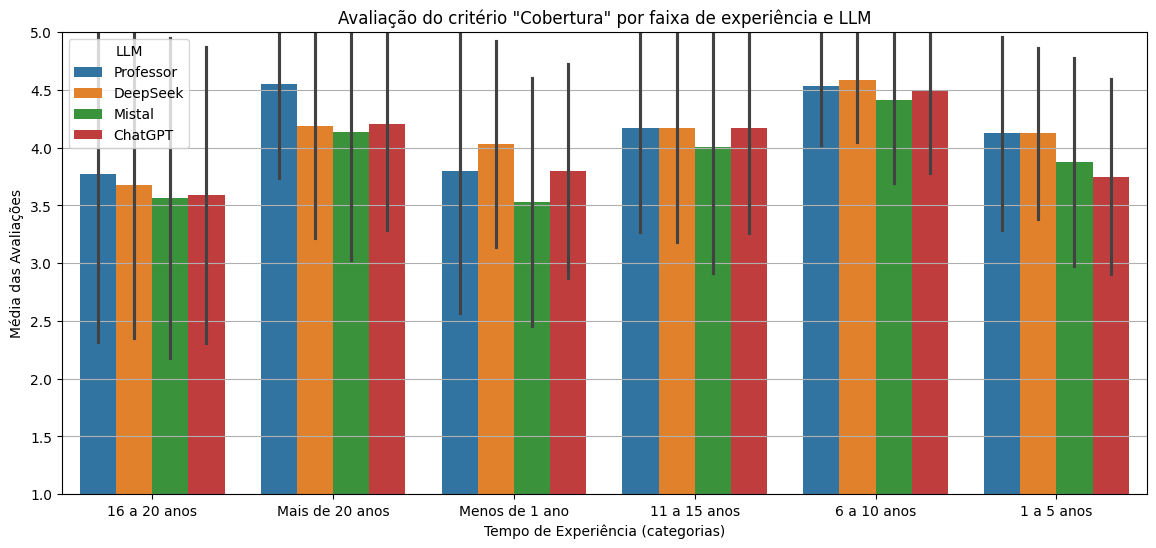

In [106]:
plt.figure(figsize=(14,6))
sns.barplot(
    data=df_long[df_long['Criterio']==criterio_exemplo],
    x='Tempo_Experiencia',
    y='Valor',
    hue='LLM',
    ci='sd',
    palette='tab10',
    dodge=True
)
plt.ylim(1,5)
plt.title(f'Avaliação do critério "{criterio_exemplo}" por faixa de experiência e LLM')
plt.ylabel('Média das Avaliações')
plt.xlabel('Tempo de Experiência (categorias)')
plt.legend(title='LLM')
plt.grid(True, axis='y')
plt.show()


4. Comparação por Titulação do Docente

/tmp/ipython-input-107-2469885839.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


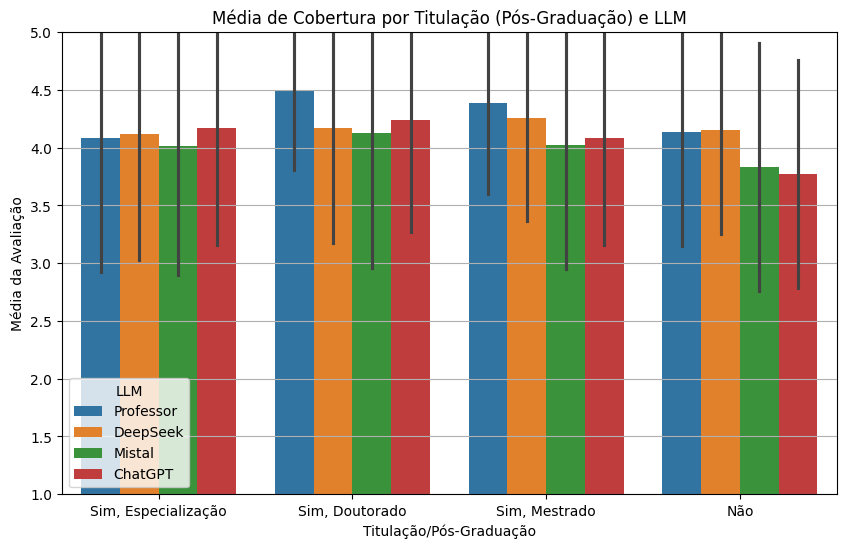

In [107]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_long[df_long['Criterio']=="Cobertura"],
    x='Pos_Graduacao',
    y='Valor',
    hue='LLM',
    ci='sd',
    palette='tab10'
)
plt.ylim(1,5)
plt.title('Média de Cobertura por Titulação (Pós-Graduação) e LLM')
plt.xlabel('Titulação/Pós-Graduação')
plt.ylabel('Média da Avaliação')
plt.legend(title='LLM')
plt.grid(True, axis='y')
plt.show()


5. Comparação por Satisfação Profissional

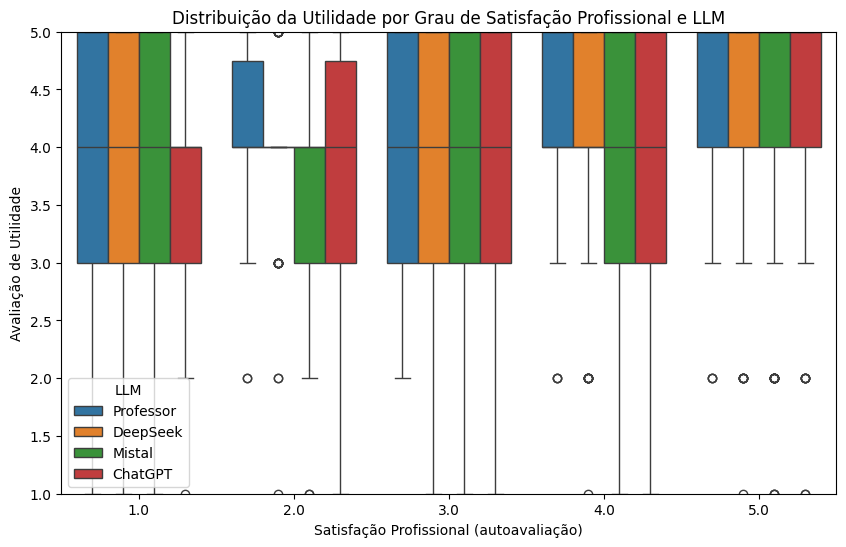

In [108]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_long[df_long['Criterio']=="Utilidade"],
    x='Satisfacao_Profissional',
    y='Valor',
    hue='LLM',
    palette='tab10'
)
plt.ylim(1,5)
plt.title('Distribuição da Utilidade por Grau de Satisfação Profissional e LLM')
plt.xlabel('Satisfação Profissional (autoavaliação)')
plt.ylabel('Avaliação de Utilidade')
plt.legend(title='LLM')
plt.show()


6. Comparação por Frequência de Elaboração de Questões

/tmp/ipython-input-109-3068335154.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


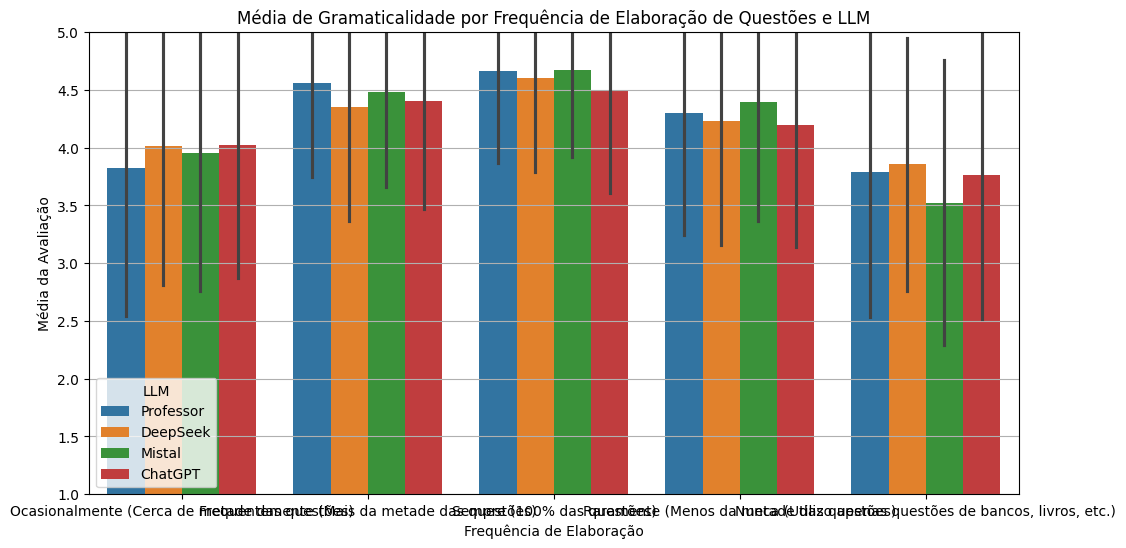

In [109]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_long[df_long['Criterio']=="Gramaticalidade"],
    x='Frequencia_Elaboracao',
    y='Valor',
    hue='LLM',
    ci='sd',
    palette='tab10'
)
plt.ylim(1,5)
plt.title('Média de Gramaticalidade por Frequência de Elaboração de Questões e LLM')
plt.xlabel('Frequência de Elaboração')
plt.ylabel('Média da Avaliação')
plt.legend(title='LLM')
plt.grid(True, axis='y')
plt.show()


7. Comparação por Nível de Estresse Autodeclarado

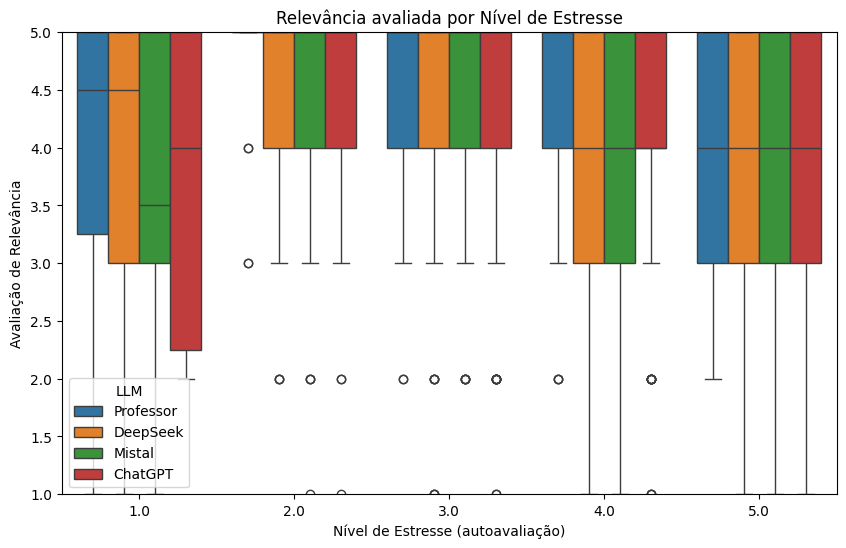

In [110]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_long[df_long['Criterio']=="Relevância"],
    x='Nivel_Estresse',
    y='Valor',
    hue='LLM',
    palette='tab10'
)
plt.ylim(1,5)
plt.title('Relevância avaliada por Nível de Estresse')
plt.xlabel('Nível de Estresse (autoavaliação)')
plt.ylabel('Avaliação de Relevância')
plt.legend(title='LLM')
plt.show()


8. Comparação por Experiência Prévia com LLMs

/tmp/ipython-input-111-2018593587.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


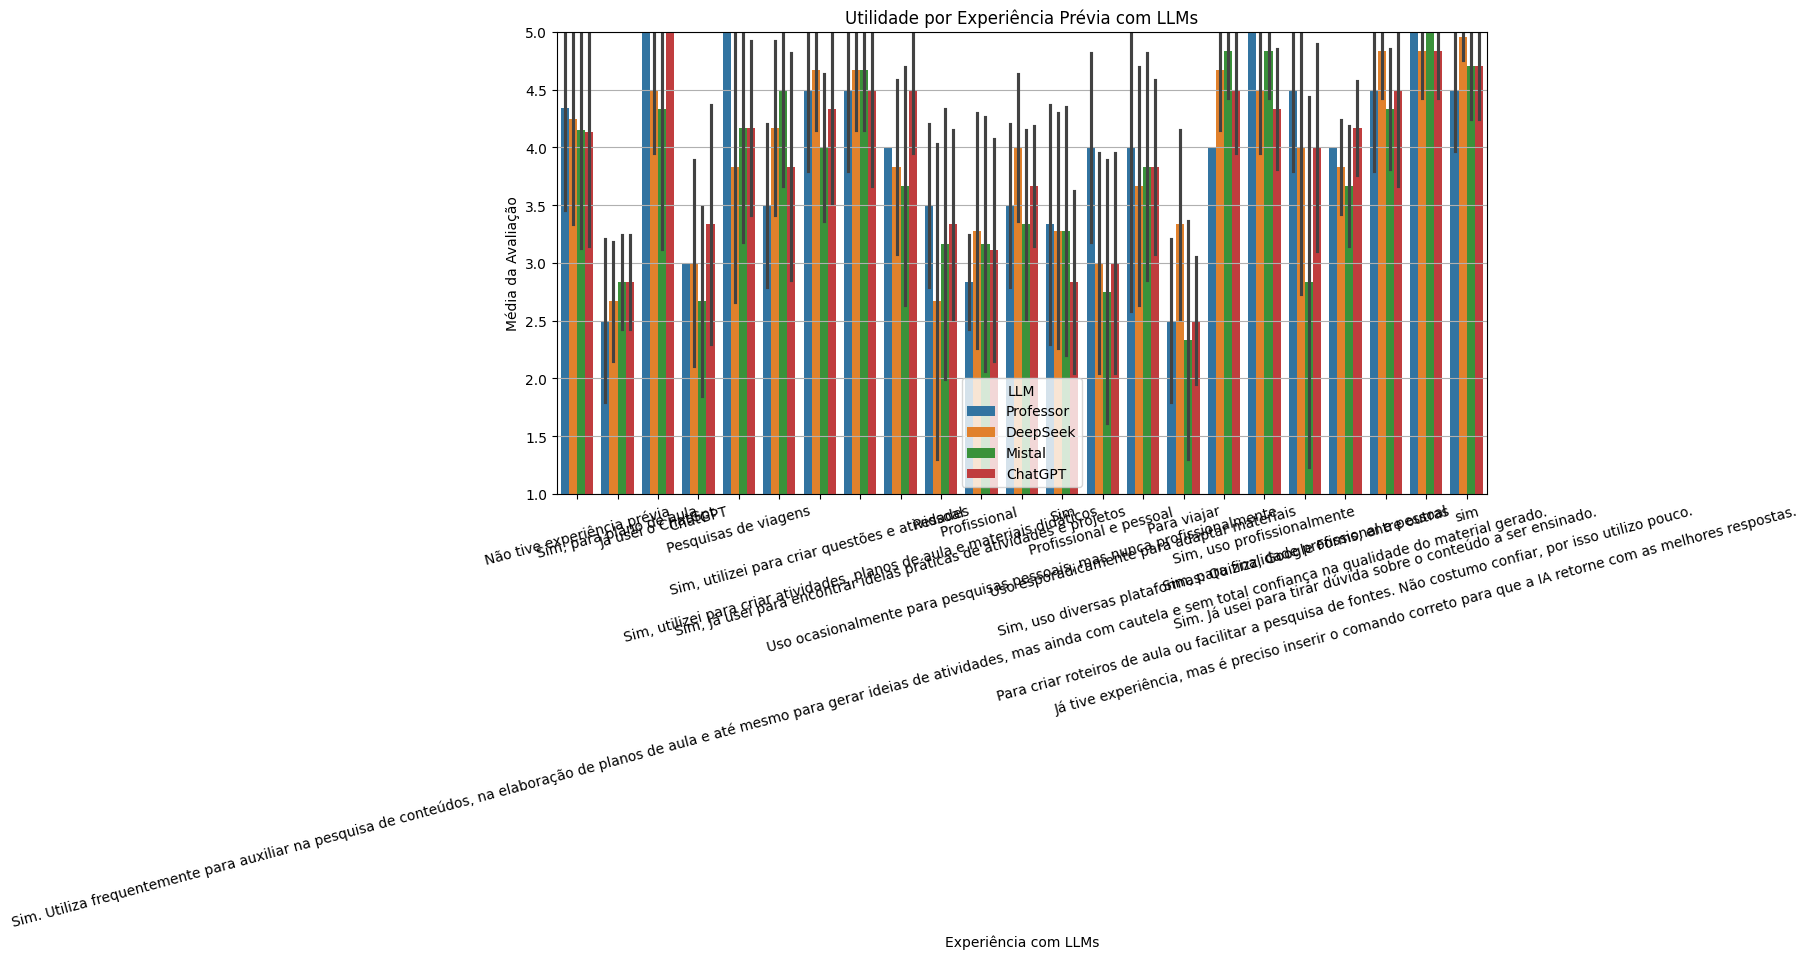

In [111]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_long[df_long['Criterio']=="Utilidade"],
    x='Experiencia_LLMs',
    y='Valor',
    hue='LLM',
    ci='sd',
    palette='tab10'
)
plt.ylim(1,5)
plt.xticks(rotation=15)
plt.title('Utilidade por Experiência Prévia com LLMs')
plt.xlabel('Experiência com LLMs')
plt.ylabel('Média da Avaliação')
plt.legend(title='LLM')
plt.grid(True, axis='y')
plt.show()

9. Segmentação Multivariada: Combinação de Perfil + Tipo de Questão

Apenas professores com "Sempre (100% das questões)" que avaliaram "Capacidade de resposta":

/tmp/ipython-input-112-3122406259.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


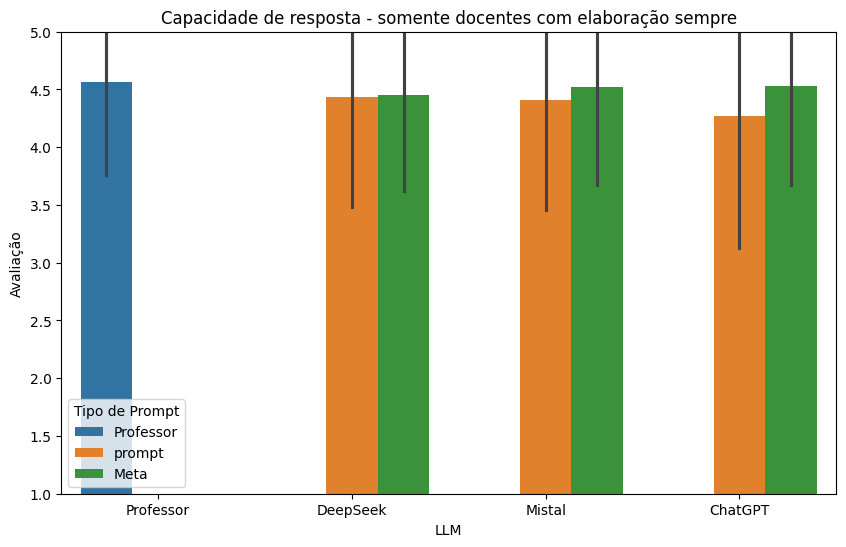

In [112]:
filtro = (
    (df_long['Frequencia_Elaboracao'] == 'Sempre (100% das questões)') &
    (df_long['Criterio'] == 'Capacidade de resposta')
)
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_long[filtro],
    x='LLM',
    y='Valor',
    hue='Tipo_Prompt',
    ci='sd',
    palette='tab10'
)
plt.ylim(1,5)
plt.title('Capacidade de resposta - somente docentes com elaboração sempre')
plt.xlabel('LLM')
plt.ylabel('Avaliação')
plt.legend(title='Tipo de Prompt')
plt.show()

In [113]:
# Exemplo: só escolas públicas e critério 'Cobertura'
pub_cob = df_long[(df_long['Instituicao'].str.contains("pública", case=False)) &
                  (df_long['Criterio']=="Cobertura")]
# Exemplo: só professores com mais de 20 anos de experiência e nível de estresse alto
estresse_alto = df_long[(df_long['Tempo_Experiencia']=="Mais de 20 anos") &
                        (df_long['Nivel_Estresse']>=4)]
# Exemplo: professores de escolas privadas, pós-graduados, que avaliam Meta do Mistal
filtro_especial = df_long[
    (df_long['Instituicao'].str.contains("privada", case=False)) &
    (df_long['Pos_Graduacao'].str.lower().str.contains("mestrado|doutorado")) &
    (df_long['LLM']=="Mistal") &
    (df_long['Tipo_Prompt']=="Meta")
]

10. LLM x Tipo de Prompt x Instituição  

Compare médias dos critérios para cada LLM/tipo de prompt em diferentes redes (pública x privada x federal, etc.):

Pode revelar diferenças entre realidades institucionais na receptividade ou exigência dos professores.

/tmp/ipython-input-114-3855512219.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


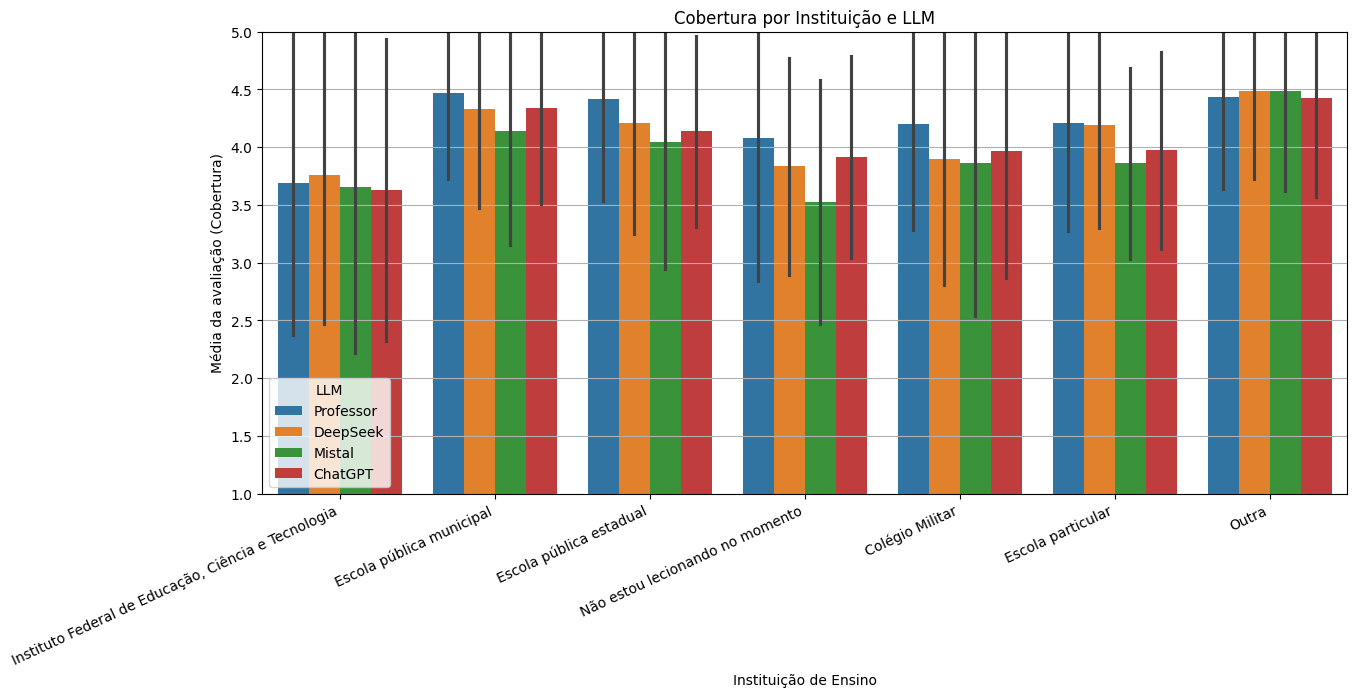

In [114]:
# Escolha um critério, por exemplo "Cobertura"
criterio = 'Cobertura'
plt.figure(figsize=(14,6))
sns.barplot(
    data=df_long[(df_long['Criterio']==criterio)],
    x='Instituicao',
    y='Valor',
    hue='LLM',
    ci='sd',
    palette='tab10'
)
plt.ylim(1,5)
plt.title(f'{criterio} por Instituição e LLM')
plt.xlabel('Instituição de Ensino')
plt.ylabel(f'Média da avaliação ({criterio})')
plt.legend(title='LLM')
plt.xticks(rotation=25, ha='right')
plt.grid(True, axis='y')
plt.show()


11.Critério x Tempo de Experiência x Tipo de Prompt  

Professores mais experientes avaliam de modo diferente as questões Meta/prompt/Professor?

Mostra se a senioridade está relacionada a uma cobrança maior (ou menor) para tipos de questão.

/tmp/ipython-input-115-606496568.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


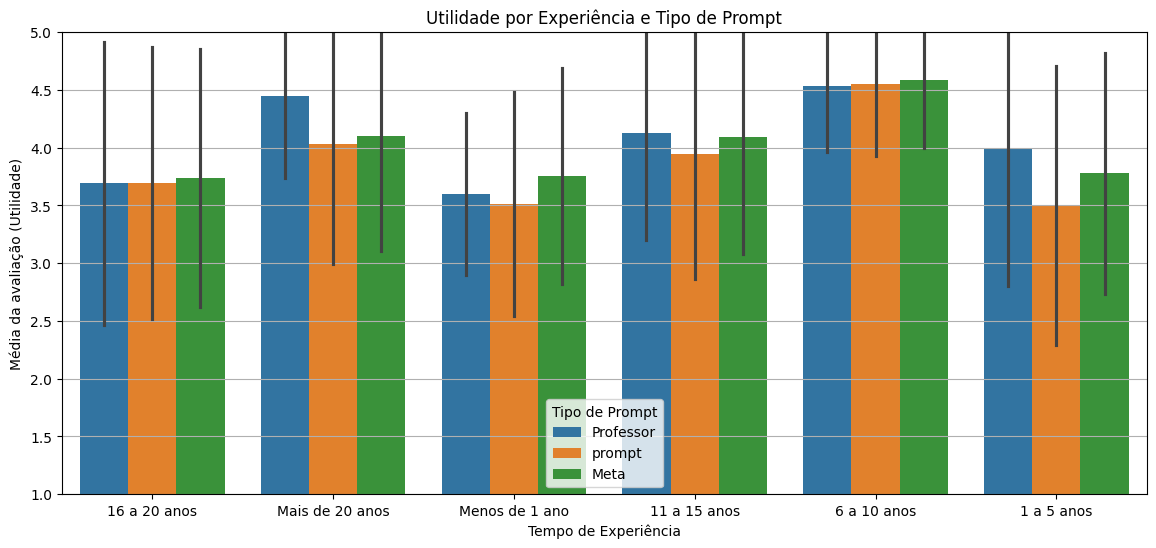

In [115]:
criterio = 'Utilidade'  # exemplo, troque se desejar
plt.figure(figsize=(14,6))
sns.barplot(
    data=df_long[df_long['Criterio']==criterio],
    x='Tempo_Experiencia',
    y='Valor',
    hue='Tipo_Prompt',
    ci='sd',
    palette='tab10'
)
plt.ylim(1,5)
plt.title(f'{criterio} por Experiência e Tipo de Prompt')
plt.xlabel('Tempo de Experiência')
plt.ylabel(f'Média da avaliação ({criterio})')
plt.legend(title='Tipo de Prompt')
plt.grid(True, axis='y')
plt.show()


12. LLM x Frequência de Elaboração de questões  

Docentes que “sempre” elaboram suas questões avaliam LLMs de modo diferente dos que “raramente” fazem isso?

Pode indicar resistência ou maior aceitação da IA conforme a prática profissional.

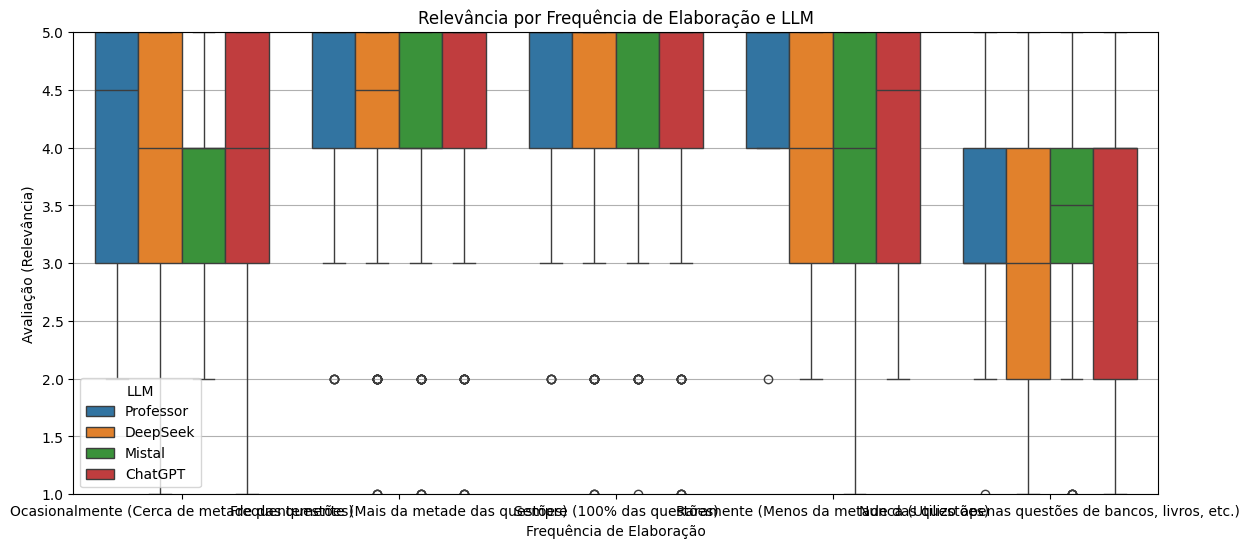

In [116]:
criterio = 'Relevância'
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df_long[df_long['Criterio']==criterio],
    x='Frequencia_Elaboracao',
    y='Valor',
    hue='LLM',
    palette='tab10'
)
plt.ylim(1,5)
plt.title(f'{criterio} por Frequência de Elaboração e LLM')
plt.xlabel('Frequência de Elaboração')
plt.ylabel(f'Avaliação ({criterio})')
plt.legend(title='LLM')
plt.grid(True, axis='y')
plt.show()


13. Critério x Pós-graduação x Tipo de Prompt  

Professores com mestrado/doutorado avaliam mais crítico ou mais benevolente que professores sem pós?

Reforça sua análise exploratória de competências docentes e visão pedagógica.

/tmp/ipython-input-117-814331226.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


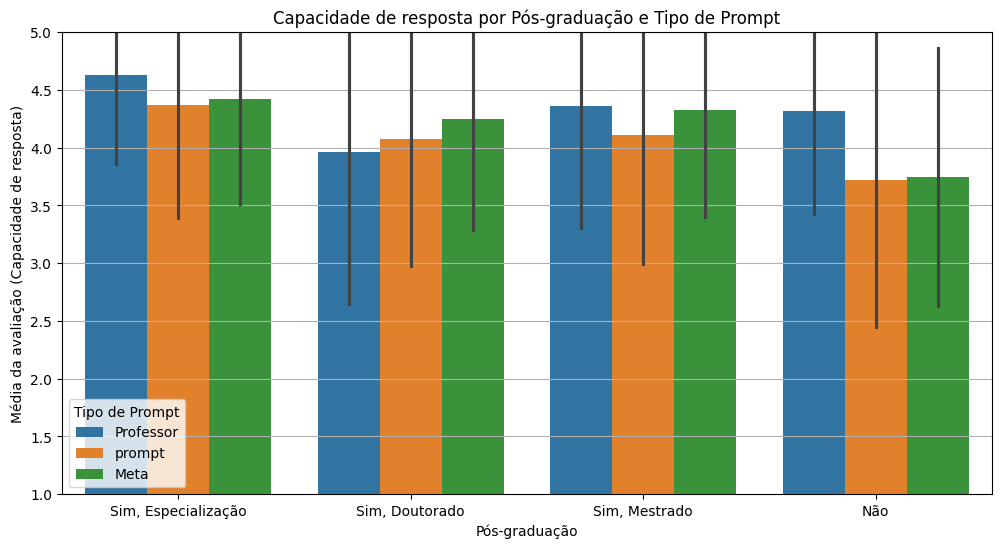

In [117]:
criterio = 'Capacidade de resposta'
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_long[df_long['Criterio']==criterio],
    x='Pos_Graduacao',
    y='Valor',
    hue='Tipo_Prompt',
    ci='sd',
    palette='tab10'
)
plt.ylim(1,5)
plt.title(f'{criterio} por Pós-graduação e Tipo de Prompt')
plt.xlabel('Pós-graduação')
plt.ylabel(f'Média da avaliação ({criterio})')
plt.legend(title='Tipo de Prompt')
plt.grid(True, axis='y')
plt.show()


14. LLM x Critério x Satisfação Profissional  

Professores mais satisfeitos dão notas mais altas para IA ou preferem avaliações humanas?

Revela relação entre valorização pessoal/profissional e aceitação de novas ferramentas.

/tmp/ipython-input-118-2928686498.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


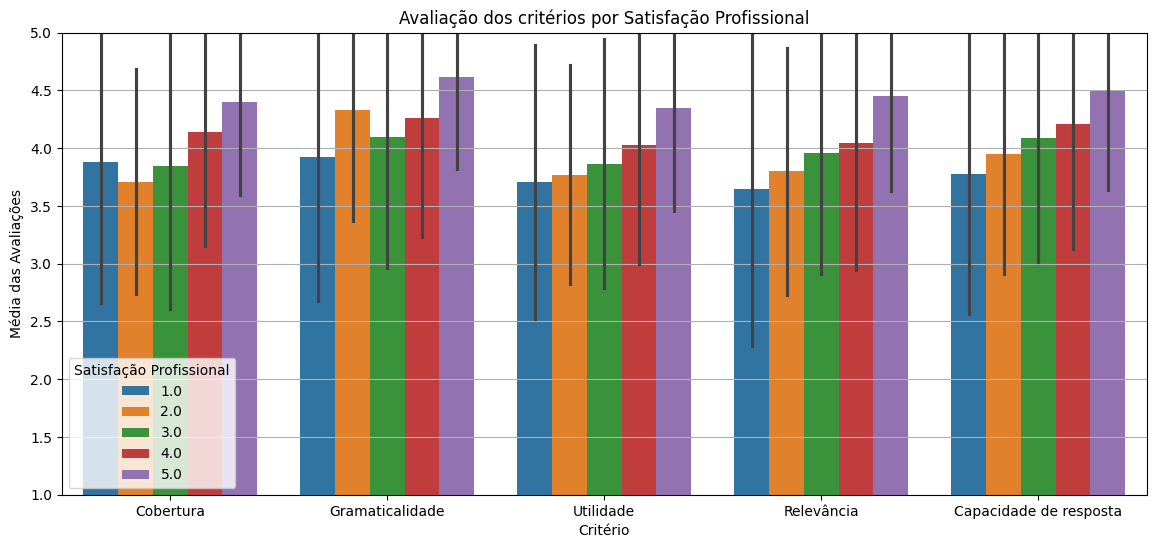

In [118]:
plt.figure(figsize=(14,6))
sns.barplot(
    data=df_long,
    x='Criterio',
    y='Valor',
    hue='Satisfacao_Profissional',
    ci='sd',
    palette='tab10'
)
plt.ylim(1,5)
plt.title('Avaliação dos critérios por Satisfação Profissional')
plt.xlabel('Critério')
plt.ylabel('Média das Avaliações')
plt.legend(title='Satisfação Profissional')
plt.grid(True, axis='y')
plt.show()


15.LLM x Critério x Experiência Prévia com LLMs  

Quem já usou LLM avalia diferente as questões de IA/Meta?

Aponta se existe viés de afinidade preexistente.

/tmp/ipython-input-119-203187704.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


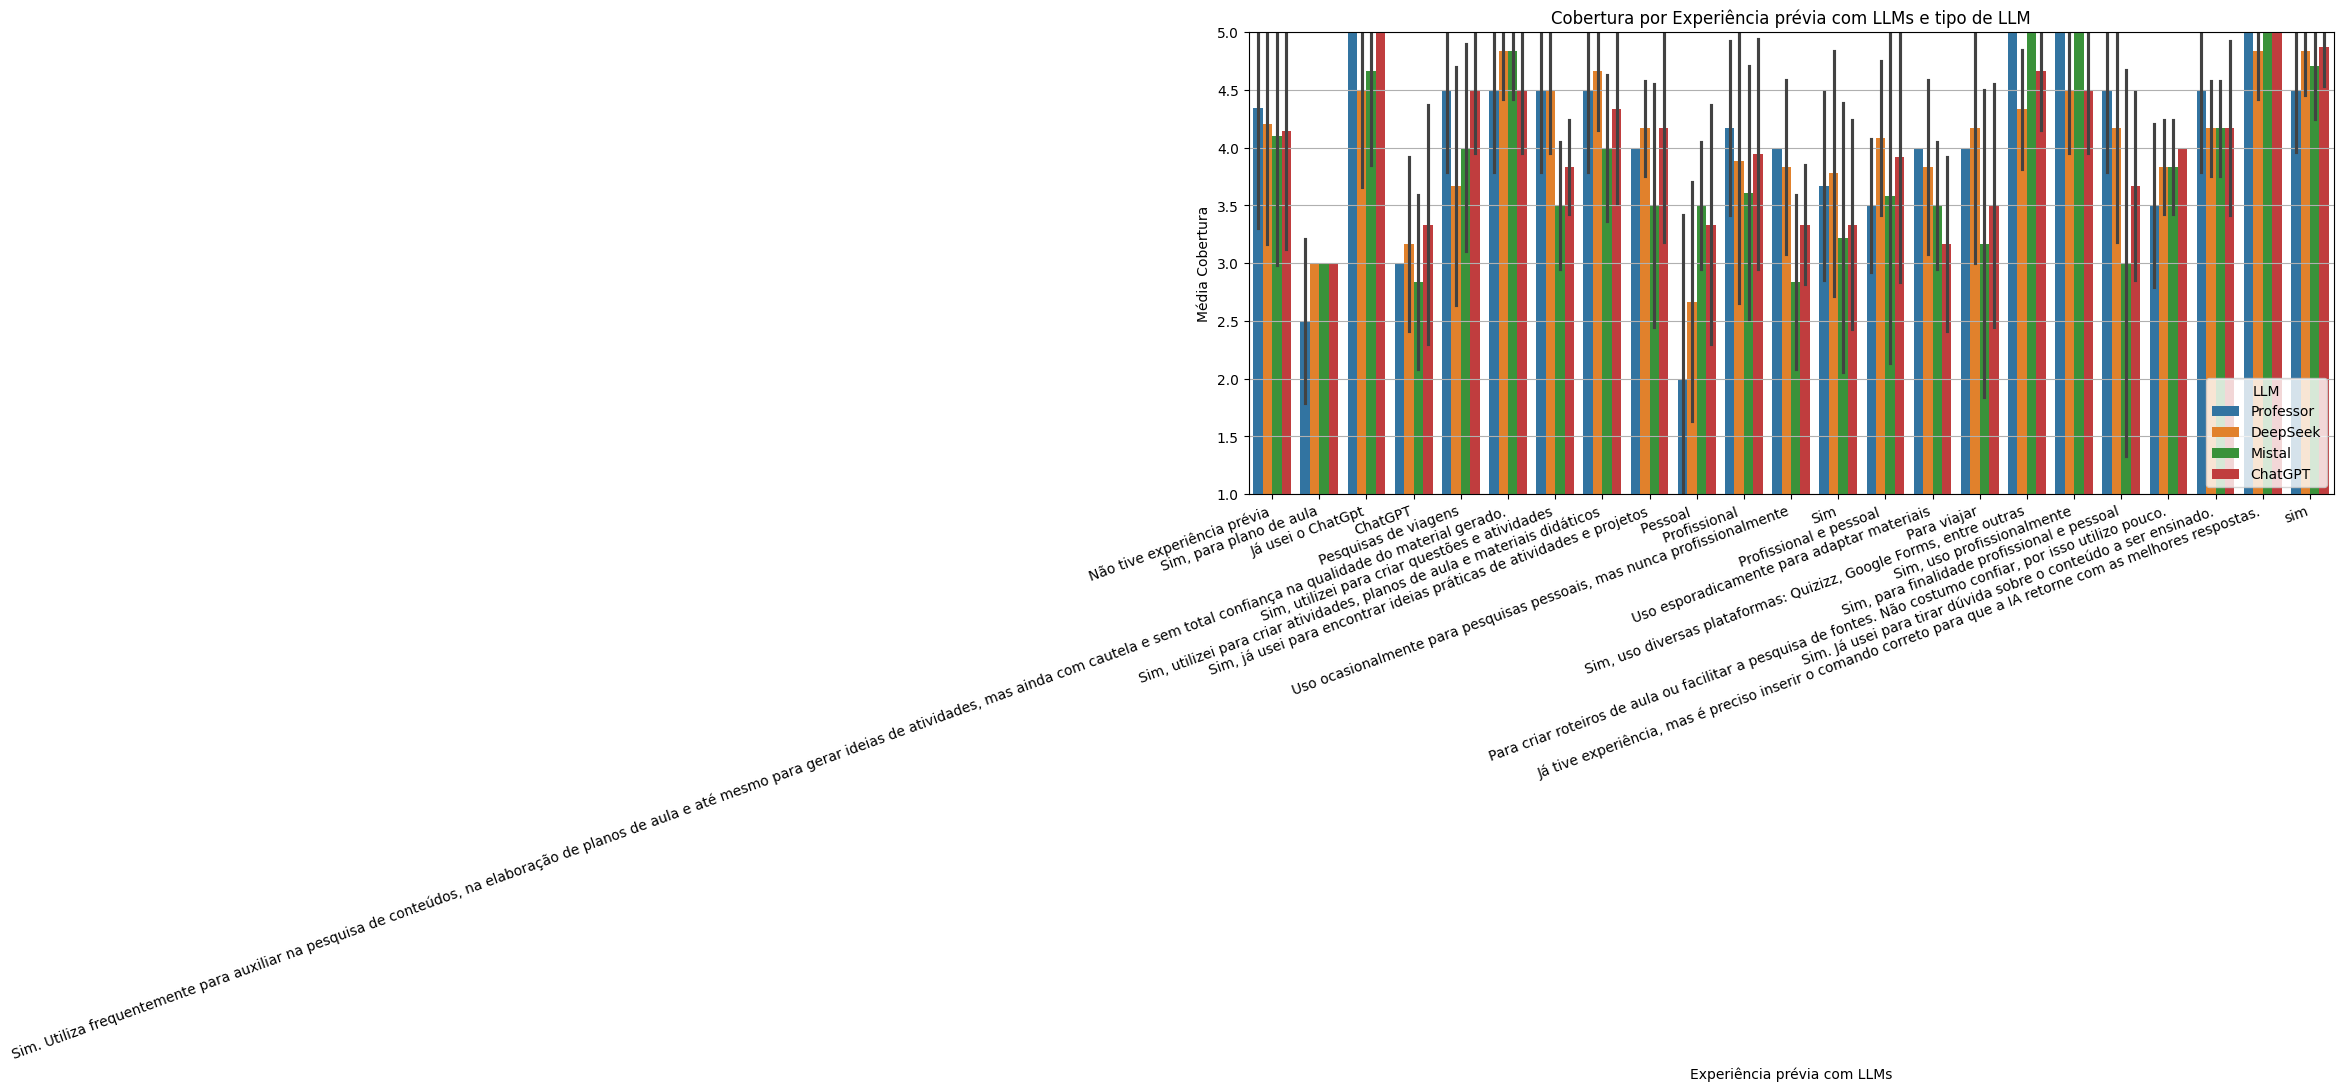

In [119]:
plt.figure(figsize=(14,6))
sns.barplot(
    data=df_long[df_long['Criterio']=="Cobertura"],
    x='Experiencia_LLMs',
    y='Valor',
    hue='LLM',
    ci='sd',
    palette='tab10'
)
plt.ylim(1,5)
plt.title('Cobertura por Experiência prévia com LLMs e tipo de LLM')
plt.xlabel('Experiência prévia com LLMs')
plt.ylabel('Média Cobertura')
plt.legend(title='LLM')
plt.grid(True, axis='y')
plt.xticks(rotation=20, ha='right')
plt.show()


16.Critério x LLM x Tipo de Prompt x Nível de Estresse

Estresse pode influenciar o valor dado a critérios de utilidade, cobertura etc.

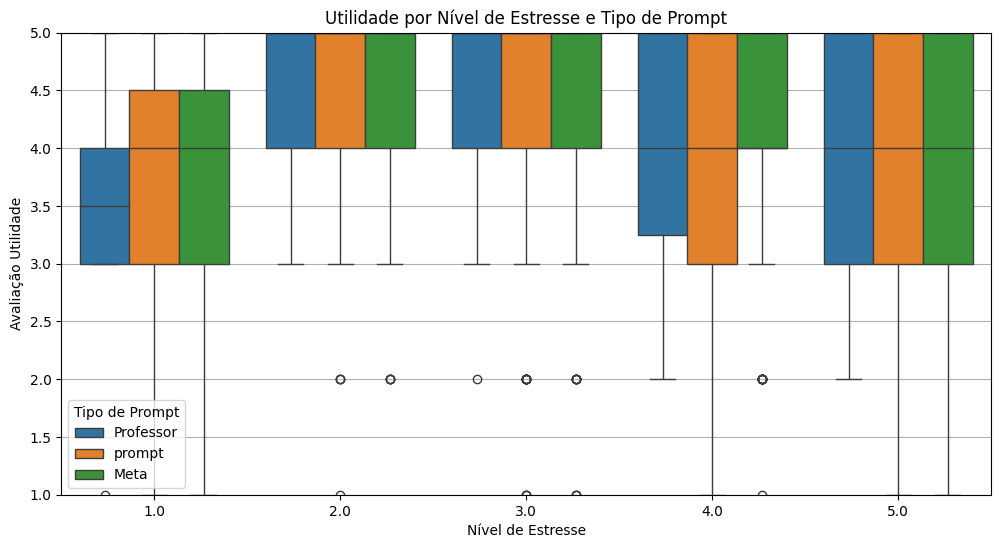

In [120]:
criterio = 'Utilidade'
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_long[df_long['Criterio']==criterio],
    x='Nivel_Estresse',
    y='Valor',
    hue='Tipo_Prompt',
    palette='tab10'
)
plt.ylim(1,5)
plt.title(f'{criterio} por Nível de Estresse e Tipo de Prompt')
plt.xlabel('Nível de Estresse')
plt.ylabel(f'Avaliação {criterio}')
plt.legend(title='Tipo de Prompt')
plt.grid(True, axis='y')
plt.show()


17.Comparar distribuição das avaliações de "Cobertura" e "Utilidade" para cada LLM/tipo de prompt, segmentando por faixa etária

/tmp/ipython-input-121-4025227014.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


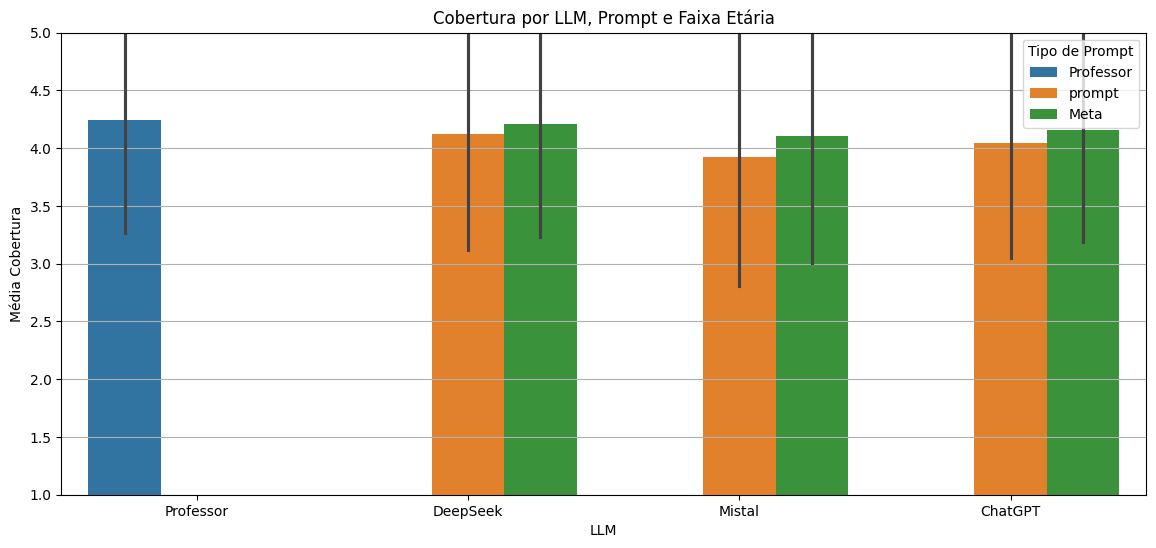

/tmp/ipython-input-121-4025227014.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


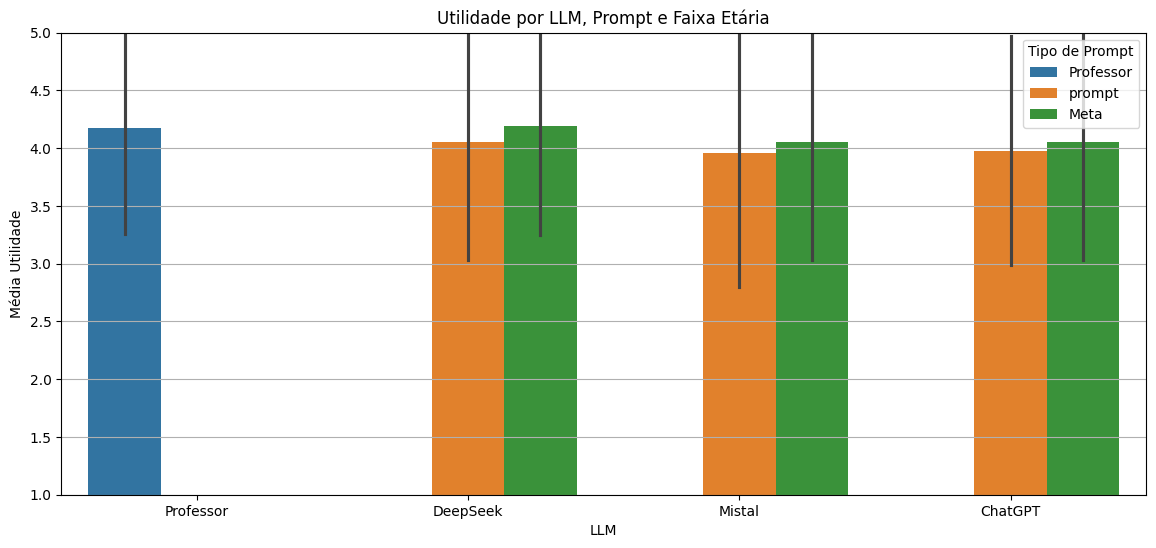

In [121]:
faixas_disponiveis = df_long['Idade'].unique()
for criterio in ['Cobertura', 'Utilidade']:
    plt.figure(figsize=(14,6))
    sns.barplot(
        data=df_long[df_long['Criterio']==criterio],
        x='LLM',
        y='Valor',
        hue='Tipo_Prompt',
        ci='sd',
        palette='tab10'
    )
    plt.ylim(1,5)
    plt.title(f'{criterio} por LLM, Prompt e Faixa Etária')
    plt.xlabel('LLM')
    plt.ylabel(f'Média {criterio}')
    plt.legend(title='Tipo de Prompt')
    plt.grid(True, axis='y')
    plt.show()

18.Avaliação das questões Meta vs Prompt em cada LLM, só para escolas públicas vs privadas

Permite entender impacto do contexto escolar.

Data type of 'Instituicao' after fillna: object
Sample values in 'Instituicao' after fillna: ['Instituto Federal de Educação, Ciência e Tecnologia'
 'Escola pública municipal' 'Escola pública estadual'
 'Não estou lecionando no momento' 'Colégio Militar' ''
 'Escola particular' 'Outra']
Number of rows in publicas: 2900
Number of rows in privadas: 1200


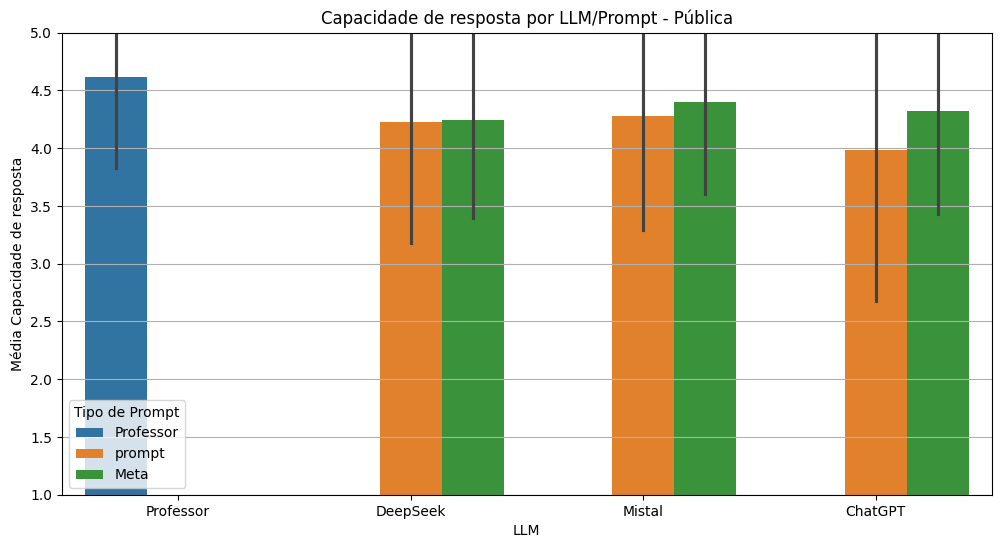

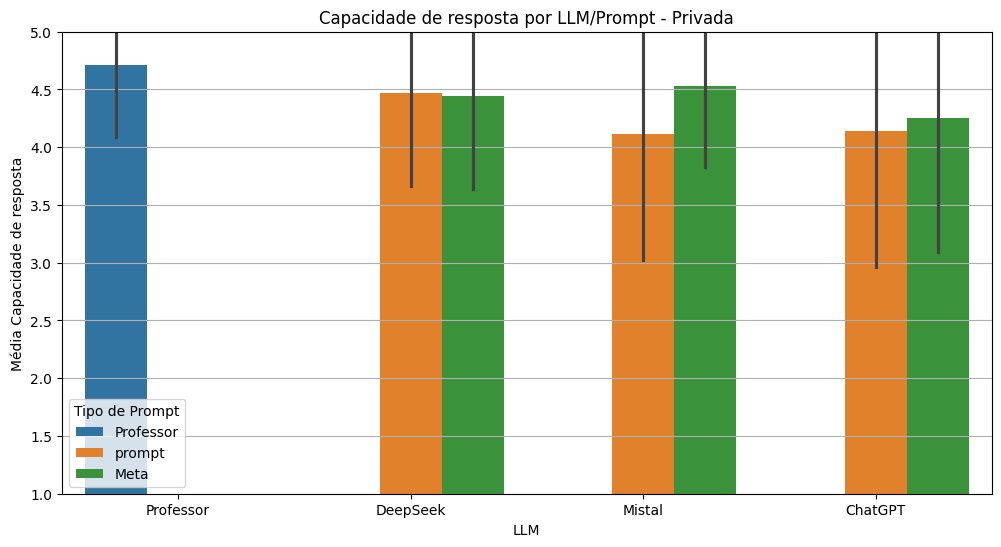

In [122]:
# Temporarily inspect the column after filling NaN
print("Data type of 'Instituicao' after fillna:", df_long['Instituicao'].fillna('').dtype)
print("Sample values in 'Instituicao' after fillna:", df_long['Instituicao'].fillna('').unique()[:10]) # Print first 10 unique values


publicas = df_long[df_long['Instituicao'].fillna('').str.lower().str.contains('pública')]
privadas = df_long[df_long['Instituicao'].fillna('').str.lower().str.contains('particular')]

# Add print statements to check the number of rows after filtering
print(f"Number of rows in publicas: {len(publicas)}")
print(f"Number of rows in privadas: {len(privadas)}")


for tipo, grupo in zip(['Pública', 'Privada'], [publicas, privadas]):
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=grupo[grupo['Criterio']=='Capacidade de resposta'],
        x='LLM',
        y='Valor',
        hue='Tipo_Prompt',
        errorbar='sd',
        palette='tab10'
    )
    plt.ylim(1,5)
    plt.title(f'Capacidade de resposta por LLM/Prompt - {tipo}')
    plt.xlabel('LLM')
    plt.ylabel('Média Capacidade de resposta')
    plt.legend(title='Tipo de Prompt')
    plt.grid(True, axis='y')
    plt.show()

19.Análise do efeito cumulativo de múltiplos filtros  

Ex: Apenas professores de escolas federais, pós-graduados, com mais de 10 anos de experiência: como avaliam o critério "Relevância" das questões Meta do ChatGPT?

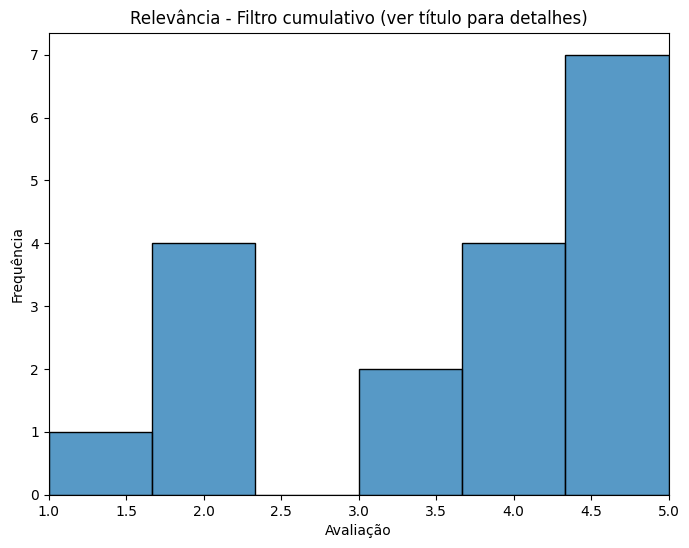

In [123]:
# Exemplo: fed. pós-graduado, mais de 10 anos de exp, para 'Relevância' Meta do ChatGPT
filtro = (
    (df_long['Instituicao'].str.lower().str.contains("federal")) &
    (df_long['Pos_Graduacao'].str.contains("Mestrado|Doutorado", case=False, regex=True)) &
    (df_long['Tempo_Experiencia'].isin(['11 a 15 anos','16 a 20 anos','Mais de 20 anos'])) &
    (df_long['LLM']=='ChatGPT') &
    (df_long['Tipo_Prompt']=='Meta') &
    (df_long['Criterio']=='Relevância')
)
plt.figure(figsize=(8,6))
sns.histplot(
    data=df_long[filtro],
    x='Valor'
)
plt.xlim(1,5)
plt.title('Relevância - Filtro cumulativo (ver título para detalhes)')
plt.xlabel('Avaliação')
plt.ylabel('Frequência')
plt.show()


# Testes estatiesticos

1. Teste ANOVA: Comparação entre grupos
Comparar médias de "Cobertura" dos três LLMs com tipos de prompt (Meta x Prompt)

O que faz:  

Compara as médias de três ou mais grupos independentes para uma variável numérica, avaliando se pelo menos um grupo difere dos outros.

Quando usar:  

Quando você quer saber, por exemplo, se a avaliação média (“Valor”) de “Cobertura” é diferente para cada LLM (ChatGPT, Mistal, DeepSeek) ou tipo de prompt (Meta, prompt).

Como funciona:

Calcula a variação média “dentro” dos grupos (ex: só ChatGPT) e “entre” os grupos.

Se a variação entre grupos for maior que a variação dentro dos grupos, o teste aponta para diferença significativa.

Resultado:

F = Estatística do teste

p = valor-p (quanto menor, mais evidencia há de diferença entre grupos; geralmente p < 0,05 indica diferença significativa)

Exemplo de uso:

ANOVA para comparar "Cobertura" de ChatGPT-Meta, Mistal-Meta e DeepSeek-Meta.

In [124]:
from scipy.stats import f_oneway

# Exemplo: ANOVA apenas para questões NÃO do Professor
mask = (
    (df_long['Criterio']=='Cobertura') &
    (df_long['LLM']!='Professor')
)
dados = df_long[mask]

# Separar grupos (cada combinação LLM+Tipo_Prompt)
grupos = []
nomes = []
for (llm, tipo), df_sub in dados.groupby(['LLM','Tipo_Prompt']):
    grupos.append(df_sub['Valor'])
    nomes.append(f"{llm}-{tipo}")

if all(len(g)>=2 for g in grupos):  # Precisa ao menos 2 valores em cada grupo
    f_stat, p_val = f_oneway(*grupos)
    print(f"ANOVA para Cobertura (LLM/Tipo_Prompt)\nF = {f_stat:.3f} | p = {p_val:.4f}")
    print("Grupos comparados:", nomes)
else:
    print("Algum grupo não tem número suficiente de casos para ANOVA.")

ANOVA para Cobertura (LLM/Tipo_Prompt)
F = nan | p = nan
Grupos comparados: ['ChatGPT-Meta', 'ChatGPT-prompt', 'DeepSeek-Meta', 'DeepSeek-prompt', 'Mistal-Meta', 'Mistal-prompt']


2. Teste Kruskal-Wallis (alternativa não-paramétrica para ANOVA)

O que faz:  

Compara três ou mais grupos, porém SEM ASSUMIR normalidade dos dados (é robusto para amostras pequenas ou com distribuições “distorcidas”).

Quando usar:

Quando ANOVA não é indicado porque os dados são ordinais, tem variâncias muito diferentes, ou amostras muito pequenas.

Exemplo: mesmos grupos de LLM/prompt, mas quando as respostas têm grandes assimetrias.

Como funciona:

Analisa as “posições” (ranks) dos valores, não a média diretamente.

Se o valor-p for pequeno (p < 0,05), indica diferença significativa entre pelo menos dois grupos.

In [125]:
from scipy.stats import kruskal

if all(len(g)>=2 for g in grupos):  # Usa os mesmos grupos criados acima!
    h_stat, p_val = kruskal(*grupos)
    print(f"Kruskal-Wallis para Cobertura (LLM/Tipo_Prompt)\nH = {h_stat:.3f} | p = {p_val:.4f}")
    print("Grupos comparados:", nomes)
else:
    print("Algum grupo não tem número suficiente de casos para Kruskal-Wallis.")

Kruskal-Wallis para Cobertura (LLM/Tipo_Prompt)
H = nan | p = nan
Grupos comparados: ['ChatGPT-Meta', 'ChatGPT-prompt', 'DeepSeek-Meta', 'DeepSeek-prompt', 'Mistal-Meta', 'Mistal-prompt']


3. Pós-Hoc (comparação par a par – Dunn ou Tukey)

Para múltiplas comparações (significativo no ANOVA/Kruskal):

O que faz:  

Depois de um ANOVA/Kruskal significativo, mostra QUEM difere de QUEM (ou seja: quais pares de grupos são diferentes, e quais não).

Quando usar:  

Após ANOVA ou Kruskal-Wallis indicar diferença geral, para saber, por exemplo:

ChatGPT-Meta difere significativamente de Mistal-Meta?

prompt ChatGPT é diferente de prompt DeepSeek?

Como funciona:

Faz comparações múltiplas, corrigindo o valor-p para o efeito de múltiplos pares.

Se p < 0,05 para o par, então os 2 grupos são estatisticamente diferentes.

In [127]:
import scikit_posthocs as sp

# Crie um vetor com identificação dos grupos
grupo_id = dados['LLM'] + "-" + dados['Tipo_Prompt']

# Verifique se há dados suficientes em cada grupo antes de executar o teste
if all(len(dados[grupo_id == g]) > 1 for g in grupo_id.unique()):
    resultado_dunn = sp.posthoc_dunn(
        dados['Valor'],  # Passa a coluna de valores como o primeiro argumento
        grupo_id,  # Passa a coluna de identificação dos grupos como o segundo argumento
        p_adjust='bonferroni'
    )
    print("Pós-hoc de Dunn (valores p):")
    print(resultado_dunn)
else:
    print("Algum grupo não tem número suficiente de casos para o teste Pós-hoc de Dunn.")

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

4. Teste para comparação entre 2 grupos: Mann-Whitney U
Comparar "Meta" vs "prompt" para ChatGPT (para o critério "Gramaticalidade"):

O que faz:  

Compara dois grupos independentes (equivalente ao t-teste, mas para dados sem normalidade).

Quando usar:  

Quando você deseja comparar, por exemplo:

“Meta” vs “prompt” para o ChatGPT

Só para um critério e modelo e só 2 grupos

Como funciona:

Compara os ranks (posições) dos valores em cada grupo.

Se p < 0,05, os grupos são diferentes em suas distribuições.

In [128]:
from scipy.stats import mannwhitneyu

g1 = df_long[(df_long['LLM']=='ChatGPT') & (df_long['Tipo_Prompt']=='Meta') & (df_long['Criterio']=='Gramaticalidade')]['Valor']
g2 = df_long[(df_long['LLM']=='ChatGPT') & (df_long['Tipo_Prompt']=='prompt') & (df_long['Criterio']=='Gramaticalidade')]['Valor']

if len(g1)>1 and len(g2)>1:
    u_stat, p_val = mannwhitneyu(g1, g2, alternative='two-sided')
    print(f'Mann-Whitney para Gramaticalidade ChatGPT (Meta vs prompt): U={u_stat} | p={p_val:.4f}')
else:
    print('Grupos pequenos demais para teste Mann-Whitney.')

Mann-Whitney para Gramaticalidade ChatGPT (Meta vs prompt): U=nan | p=nan


5. Cruzamento com perfil docente ( experiência)
ANOVA para “Utilidade” por experiência docente:

(Iguais às anteriores, mas comparando grupos de perfil: faixa de experiência, satisfação, etc.)

Use para responder perguntas como:

“O tempo de experiência faz diferença na avaliação de utilidade das questões?”

Do mesmo modo, calcula diferenças entre médias (ou ranks) para os grupos definidos pela coluna de perfil.

6. Crosstab/pivot

Apenas cria tabelas cruzando grupos, ex: quantos avaliaram cada modelo/tipo.

Como relatar/interpretar

Se p valor < 0,05 → diferença estatística detectada (mas sempre contextualize com médias, desvios e importância prática!)

Cite sempre que grupos com n<5 podem comprometer robustez do resultado.

Se a diferença aparece só nos testes pós-hoc: só os grupos daquele par têm diferença, os demais não.

In [129]:
from scipy.stats import f_oneway

grupos_exp = []
nomes_exp = []
for te, grupo in df_long[df_long['Criterio']=='Utilidade'].groupby('Tempo_Experiencia'):
    grupos_exp.append(grupo['Valor'])
    nomes_exp.append(str(te))

if all(len(g)>=2 for g in grupos_exp):
    f_stat, p_val = f_oneway(*grupos_exp)
    print(f"ANOVA para Utilidade (por experiência)\nF = {f_stat:.3f} | p = {p_val:.4f}")
    print("Grupos comparados:", nomes_exp)
else:
    print("Algum grupo não tem dados suficientes para ANOVA.")

ANOVA para Utilidade (por experiência)
F = 30.384 | p = 0.0000
Grupos comparados: ['1 a 5 anos', '11 a 15 anos', '16 a 20 anos', '6 a 10 anos', 'Mais de 20 anos', 'Menos de 1 ano']


Resumindo:

ANOVA/Kruskal: diferença geral entre 3+ grupos

Pós-hoc: quem difere de quem

Mann-Whitney: diferença entre só 2 grupos

Crosstab: distribuição (sem teste estatístico)

Esses são os principais métodos para validar, com rigor, o que os gráficos e as médias sugerem de forma mais visual.

Se quiser textos-exemplo para relatar ANOVA ou outra na dissertação, só pedir!

# Outras analises

1. Boxplots para Detecção de Outliers/Dispersão
Permitem verificar não só médias, mas a distribuição, presença de valores extremos e simetria/asimetria nas avaliações.

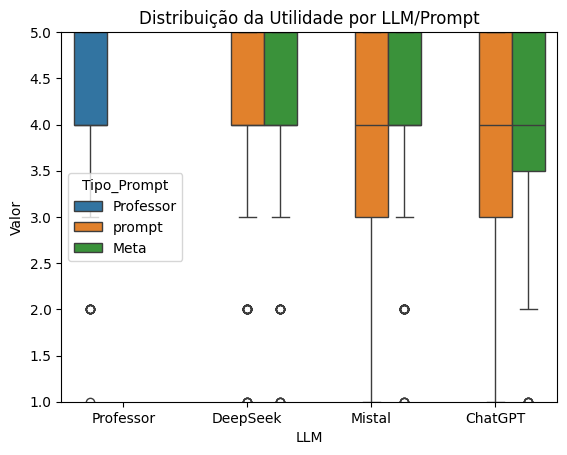

In [130]:
sns.boxplot(data=df_long[df_long['Criterio']=="Utilidade"], x="LLM", y="Valor", hue="Tipo_Prompt")
plt.title("Distribuição da Utilidade por LLM/Prompt")
plt.ylim(1,5)
plt.show()


2. Heatmap de Correlação Entre Critérios
Analisa se quem avalia bem em "Cobertura" tende a avaliar bem em "Utilidade", "Relevância" etc. Ajuda a revelar relações entre os critérios.

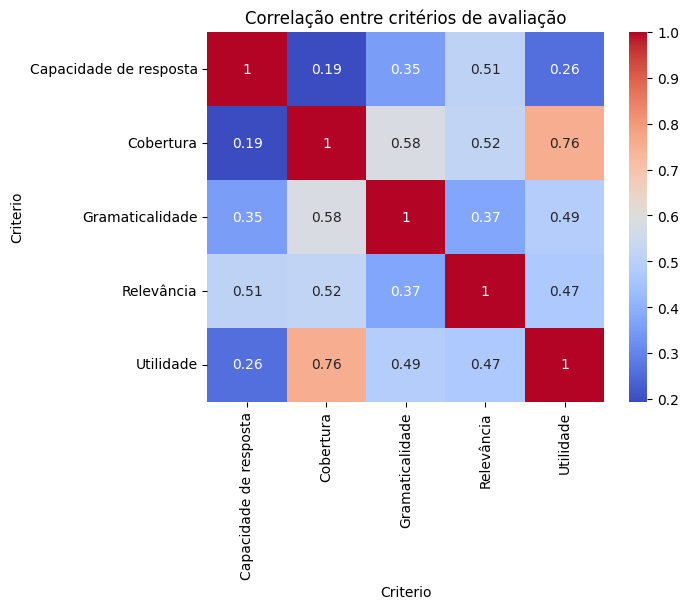

In [131]:
tabela_pivot = df_long.pivot_table(index='Questao', columns='Criterio', values='Valor', aggfunc='mean')
sns.heatmap(tabela_pivot.corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre critérios de avaliação')
plt.show()


3. Análise de Tendência por Ordem de Questão
Ver se há efeito de cansaço/ordem (avaliadores ficando mais rigorosos ou benevolentes nas últimas questões).

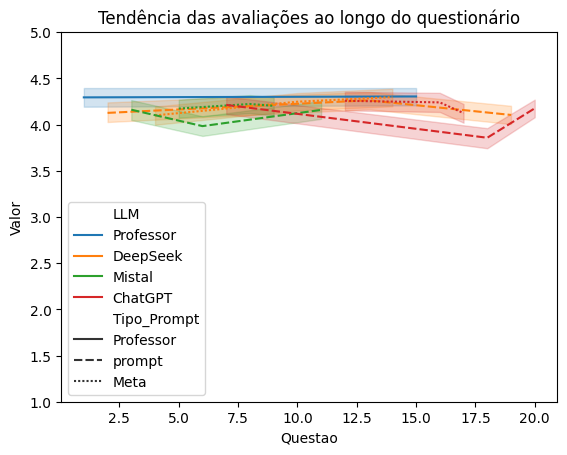

In [132]:
sns.lineplot(data=df_long, x='Questao', y='Valor', hue='LLM', style='Tipo_Prompt')
plt.ylim(1,5)
plt.title('Tendência das avaliações ao longo do questionário')
plt.show()


4. Análise dos Itens mais e menos bem avaliados
Quais questões/tipos/modelos receberam notas mais baixas ou mais altas? Dá para listar as TOP 5/baixo 5 para cada critério.

In [133]:
top_baixas = df_long[df_long['Criterio']=='Utilidade'].sort_values('Valor').head(5)
top_altas = df_long[df_long['Criterio']=='Utilidade'].sort_values('Valor', ascending=False).head(5)
print('Mais baixas:', top_baixas[['Questao','LLM','Tipo_Prompt','Valor']])
print('Mais altas:', top_altas[['Questao','LLM','Tipo_Prompt','Valor']])


Mais baixas:       Questao      LLM Tipo_Prompt  Valor
4777       16  ChatGPT        Meta    1.0
4682       17  ChatGPT        Meta    1.0
4612        3   Mistal      prompt    1.0
5022        5   Mistal        Meta    1.0
3637        8   Mistal        Meta    1.0
Mais altas:       Questao        LLM Tipo_Prompt  Valor
8497       20    ChatGPT      prompt    5.0
8487       18    ChatGPT      prompt    5.0
8402        1  Professor   Professor    5.0
8392       19   DeepSeek      prompt    5.0
8382       17    ChatGPT        Meta    5.0


5. Tabela de Frequências Absolutas/Relativas das notas
Quanto das respostas ficou em cada valor da escala? Ajuda a ver concentração de respostas ou polarização.

In [134]:
freq = df_long['Valor'].value_counts().sort_index()
print(freq)


Valor
1.0     180
2.0     537
3.0    1059
4.0    2236
5.0    4088
Name: count, dtype: int64


6. Perfil dos Avaliadores Extremamente Positivos/Negativos
Filtrar e descrever o perfil dos docentes que usam sempre notas muito altas ou muito baixas (podem indicar viés).

In [135]:
extremos = df_long[(df_long['Valor']==5) | (df_long['Valor']==1)]
print(extremos[['Idade','Tempo_Experiencia','LLM','Tipo_Prompt','Valor']].groupby(['LLM','Tipo_Prompt','Valor']).size())


LLM        Tipo_Prompt  Valor
ChatGPT    Meta         1.0       22
                        5.0      630
           prompt       1.0       33
                        5.0      553
DeepSeek   Meta         1.0       27
                        5.0      624
           prompt       1.0       26
                        5.0      596
Mistal     Meta         1.0       23
                        5.0      627
           prompt       1.0       37
                        5.0      595
Professor  Professor    1.0       12
                        5.0      463
dtype: int64


7. Regressão Simples ou Múltipla (se quiser ir além)
Usar regressão linear para identificar que perfil de docente mais influencia a nota (experiência, satisfação, uso prévio de IA, etc.).

In [136]:
import statsmodels.formula.api as smf
df_long['Valor'] = pd.to_numeric(df_long['Valor'], errors='coerce')  # certifique-se que é numérica
modelo = smf.ols('Valor ~ C(LLM) + C(Tipo_Prompt) + Tempo_Experiencia_Num + C(Pos_Graduacao)', data=df_long).fit()
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:                  Valor   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     33.97
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           3.46e-53
Time:                        00:21:38   Log-Likelihood:                -11634.
No. Observations:                8100   AIC:                         2.329e+04
Df Residuals:                    8091   BIC:                         2.335e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

8. Análise de Concordância entre Professores
Nota: Esse teste (por exemplo, Fleiss’ Kappa) faz sentido se várias pessoas avaliaram exatamente as MESMAS questões, e você quer medir quanto elas tendem a concordar (além do acaso).

O exemplo abaixo calcula a matriz de concordância para todas as avaliações de cada (Questão, Critério, LLM, Tipo_Prompt):

In [138]:
# É preciso que diferentes professores tenham avaliado as mesmas questões.
# Adiciona um identificador único para cada questão analisada:
df_long['id_item'] = (
    df_long['Questao'].astype(str) + "_" +
    df_long['Criterio'] + "_" +
    df_long['LLM'] + "_" +
    df_long['Tipo_Prompt']
)

# Crie uma matriz: linhas são docentes, colunas são itens, valores são notas
# É preciso definir um identificador de respondente (ex: timestamp ou nome):
if 'Carimbo de data/hora' in df_long.columns:
    idx_avaliador = 'Carimbo de data/hora'
else:
    idx_avaliador = df_long.index  # ajuste se houver campo melhor

matriz_concordancia = df_long.pivot_table(
    index=idx_avaliador,
    columns='id_item',
    values='Valor'
)

# Para Kappa multigrupo (Fleiss), cada coluna deve ser categórica:
from statsmodels.stats.inter_rater import fleiss_kappa
import numpy as np

# Converta notas em int (caso estejam como float), e padronize categorias:
cat_mat = matriz_concordancia.apply(lambda x: pd.Categorical(x, categories=[1,2,3,4,5]).codes, axis=0).T

# Fleiss Kappa só faz sentido se o número de ratings por item for o mesmo!
# Então filtra apenas colunas/item totalmente preenchidas.
cat_mat_clean = cat_mat.T.dropna(axis=1, how='any').T

if cat_mat_clean.shape[1] > 1:  # precisa de pelo menos 2 itens avaliados por todos
    kappa = fleiss_kappa(cat_mat_clean.astype(int).values)
    print(f"Fleiss' Kappa de concordância múltipla: {kappa:.3f}")
else:
    print('Não há itens avaliados por todos necessários para o cálculo do Kappa.')

AssertionError: 

9. Análise de Segmentos Específicos (nichos)
Exemplo: comparar médias de “Relevância” apenas para professores de escolas federais, e só mostrando o LLM “Mistal”:

In [139]:
filtro_nicho = (
    df_long['Instituicao'].str.lower().str.contains("federal") &
    (df_long['LLM'] == 'Mistal') &
    (df_long['Criterio'] == 'Relevância')
)
media_nicho = (
    df_long[filtro_nicho]
    .groupby(['Tipo_Prompt'])['Valor']
    .agg(['mean','std','count'])
)
print(media_nicho)

                 mean       std  count
Tipo_Prompt                           
Meta         3.794872  1.030572     39
prompt       3.871795  1.217839     39


10. Análise Temporal
Se o campo “Carimbo de data/hora” representa a data de avaliação, veja como a média das notas evoluiu com o tempo ou dias diferentes.

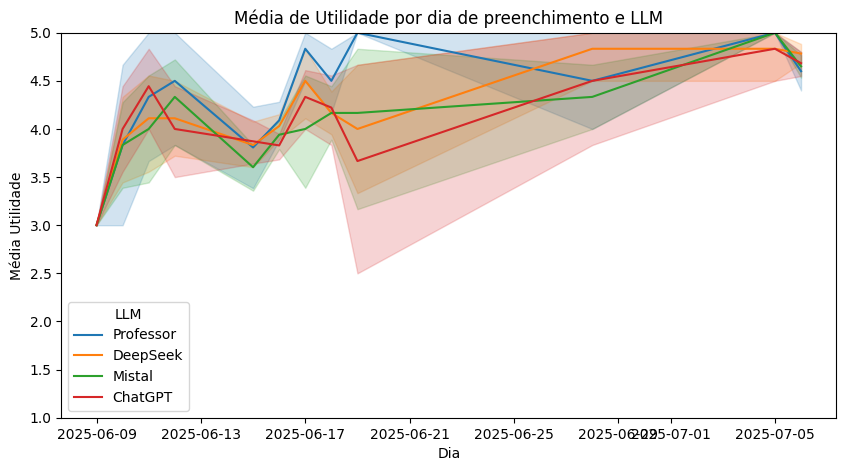

In [140]:
df_long['data'] = pd.to_datetime(df_long['Carimbo de data/hora'])
df_long['dia'] = df_long['data'].dt.date

# Exemplo: evolução das médias de "Utilidade"
plt.figure(figsize=(10,5))
sns.lineplot(data=df_long[df_long['Criterio']=='Utilidade'], x='dia', y='Valor', hue='LLM')
plt.ylim(1,5)
plt.title('Média de Utilidade por dia de preenchimento e LLM')
plt.xlabel('Dia')
plt.ylabel('Média Utilidade')
plt.show()


11. Gráficos de Densidade/KDE
Veja como se distribuem as avaliações para um critério específico (ex: “Cobertura”), em vez de só médias:

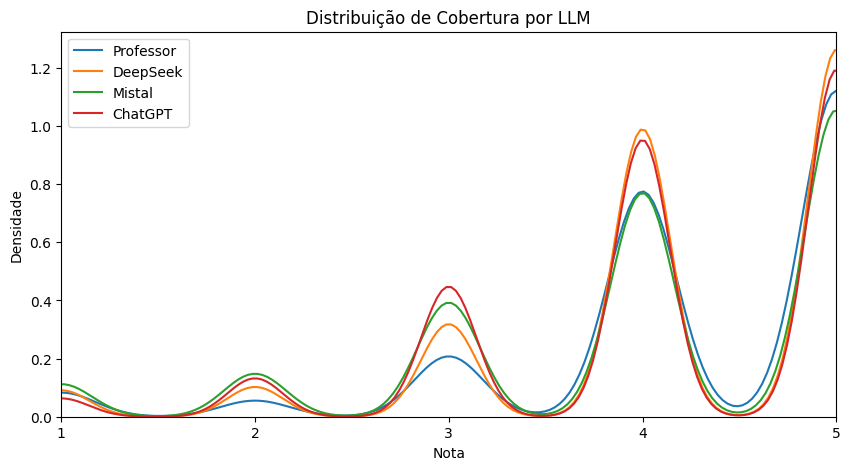

In [141]:
plt.figure(figsize=(10,5))
for llm in df_long['LLM'].unique():
    sns.kdeplot(
        data=df_long[(df_long['Criterio']=='Cobertura') & (df_long['LLM']==llm)],
        x='Valor',
        label=llm,
        bw_adjust=0.5, # Ajuste a suavização conforme necessário
        common_norm=False
    )
plt.xlim(1,5)
plt.xticks([1,2,3,4,5])
plt.title('Distribuição de Cobertura por LLM')
plt.xlabel('Nota')
plt.ylabel('Densidade')
plt.legend()
plt.show()


12. Clusterização dos Professores por padrão de resposta
Identifique tipos de avaliador: rigoroso, generoso, etc. (via k-means para perfis de resposta nos critérios).

In [142]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Pivot: cada docente é uma linha, variáveis são médias de critério (ou LLM, ou Tipo Prompt, etc.)
id_avaliador = 'Carimbo de data/hora'
perfil_df = df_long.pivot_table(
    index=id_avaliador,
    columns='Criterio',
    values='Valor',
    aggfunc='mean'
).fillna(3)  # preencher missings com neutro

# Normaliza os dados
scaler = StandardScaler()
perfil_scaled = scaler.fit_transform(perfil_df)

# Número de clusters (defina conforme teste: 2 = rígido x generoso, 3 ou mais para mais perfis)
kmeans = KMeans(n_clusters=3, random_state=42)
perfil_df['Cluster'] = kmeans.fit_predict(perfil_scaled)

print(perfil_df.groupby('Cluster').mean())
print('Distribuição nos clusters:', perfil_df['Cluster'].value_counts())


Criterio  Capacidade de resposta  Cobertura  Gramaticalidade  Relevância  \
Cluster                                                                    
0                       3.206818   3.406818         3.270455    3.036364   
1                       4.611207   4.431034         4.791379    4.537069   
2                       5.000000   1.000000         2.000000    4.000000   

Criterio  Utilidade  
Cluster              
0          3.027273  
1          4.472414  
2          3.000000  
Distribuição nos clusters: Cluster
1    58
0    22
2     1
Name: count, dtype: int64
